# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
kb = 3.1668105e-06 # in hartree
ha2ev = 27.211386
kbev = kb*ha2ev # in eV
T0=90
natomfcc=1440
natomsf=1320
nfreefcc=(natomfcc-1)*3
nfreesf=(natomsf-1)*3

## The energy units in this notebook is in eV, unless specified otherwise

# 0K results

In [3]:
U0fcc=-6314.22505162  # in eV
U0sf=-5789.39486417
print U0sf-U0fcc*natomsf/natomfcc

-1.35523351833


# The free energy of the reference harmonic system with fixed mass at 90K
### $A_\text{h}(T_0)=k_B T_0\sum_{i=1}^{3N-3}\ln(\dfrac{\hbar \omega_i}{k_B T_0})$

In [5]:
T0=90
eva = np.loadtxt("ipi-90K/phonon-0K/fcc-0K.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmfccT0 = ha2ev*T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()
print AharmfccT0

39.562788027


In [6]:
eva = np.loadtxt("ipi-90K/phonon-0K/sf-0K.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmsfT0 = ha2ev*T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()
print AharmsfT0

36.4887656156


In [7]:
(AharmsfT0-AharmfccT0*11/12)

0.22287659082002875

# Anharmonic correction of A at 90K
### $A(V,T_0)-A_\text{h}(V,T_0)=\int_0^1 d \lambda \left<U-U_\text{h}\right>_{V,T_0,\lambda}$

In [8]:
dhdlfcc = np.loadtxt("ipi-90K/lambda-ti/dhdl.fcc")
it=0.0
iterror=0.0
for i in xrange(len(dhdlfcc)-1):
    #print dhdlfcc[i,0],dhdlfcc[i,1]
    it += 0.5*(dhdlfcc[i,1]+dhdlfcc[i+1,1])*(dhdlfcc[i+1,0]-dhdlfcc[i,0])
    iterror += 0.5*(dhdlfcc[i,2]**2.+dhdlfcc[i,2]**2.)*(dhdlfcc[i+1,0]-dhdlfcc[i,0])
print it, iterror
AanhfccT0=it
AanhfccT0error=iterror
AfccT0=AharmfccT0+AanhfccT0
print AharmfccT0, U0fcc, AanhfccT0
print AfccT0, "+/-", AanhfccT0error

-6314.144845 2.56724487623e-07
39.562788027 -6314.22505162 -6314.144845
-6274.58205697 +/- 2.56724487623e-07


In [9]:
dhdlsf = np.loadtxt("ipi-90K/lambda-ti/dhdl.sf")
it=0.0
iterror=0.0
for i in xrange(len(dhdlsf)-1):
    it += 0.5*(dhdlsf[i,1]+dhdlsf[i+1,1])*(dhdlsf[i+1,0]-dhdlsf[i,0])
    iterror += 0.5*(dhdlsf[i,2]**2.+dhdlsf[i,2]**2.)*(dhdlsf[i+1,0]-dhdlsf[i,0])
print it, iterror
AanhsfT0=it
AanhsfT0error=iterror
AsfT0=AharmsfT0+AanhsfT0
print AharmsfT0, U0sf, AanhsfT0
print AsfT0, "+/-", AanhsfT0error

-5789.321835 2.57881575922e-07
36.4887656156 -5789.39486417 -5789.321835
-5752.83306938 +/- 2.57881575922e-07


# Transform the Helmholtz free energy to the Gibbs free energy
#### We used the isothermal-isobaric ensemble (NPT) in the simulations with zero external pressure, and allowed the 3 dimensions of the orthorhombic simulation cell are allowed to fluctuate independently. In this case we have
#### $G(P,T) = A (\textbf{h},T) + P \text{det}(\textbf{h}) + k_B T \ln \rho(\textbf{h}|P,T)$.
#### As $P=0$ in our case, so here we only need to compute $k_B T \ln \rho(\textbf{h}|P,T)$
#### For convinience, we used a bash script (processrhoxyz.sh) to compute this quantity.

In [10]:
A2GfccT0=[0.0325523, 8.78027e-05]
A2GsfT0=[0.0344483, 7.2773e-05]

GfccT0=AfccT0+A2GfccT0[0]
GfccT0error=AanhfccT0error+A2GfccT0[1]
print "Gfcc90K:",GfccT0, "+/-", GfccT0error

GsfT0=AsfT0+A2GsfT0[0]
GsfT0error=AanhsfT0error+A2GsfT0[1]
print "Gsf 90K:",GsfT0, "+/-", GsfT0error


Gfcc90K: -6274.54950467 +/- 8.80594244876e-05
Gsf 90K: -5752.79862108 +/- 7.30308815759e-05


# Thermodynamic Intergation at NPT
## $-T_1\int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{ T^2} dT=-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$,

## In our case P=0 so $H=U$

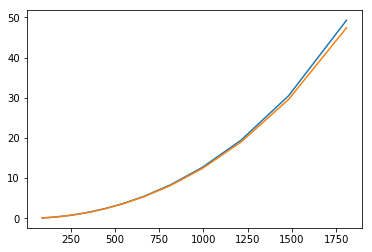

In [12]:
dhnptlist = np.sort(np.loadtxt("lammps-npt/PE.list"), axis=0)
#print dhnptlist
ttnpt = dhnptlist[:,0]
ltnpt = np.log(ttnpt)
#print ttnpt

dhfcc = dhnptlist[:,1]
dhfccerror = dhnptlist[:,2]
dhsf = dhnptlist[:,3]
dhsferror = dhnptlist[:,4]
for a in xrange(len(ttnpt)):
    dhfcc[a] += -U0fcc- ttnpt[a]*kbev*nfreefcc/2.
    dhsf[a] += -U0sf- ttnpt[a]*kbev*nfreesf/2.
    
plt.plot(ttnpt,dhfcc)
plt.plot(ttnpt,dhsf)
plt.show()

#### TI wrt T, starting at T_0=90K

In [13]:
intdhfcc=np.zeros((len(ttnpt)-1,3))
it=0.0
iterror=0.0
for i in xrange(len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhfcc[i]/ttnpt[i]+dhfcc[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhfccerror[i]/ttnpt[i])**2.+(dhfccerror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhfcc[i,0]=T1
    intdhfcc[i,1]=-it*T1
    intdhfcc[i,2]=np.sqrt(iterror)*T1
#print intdhfcc
#plt.plot(intdhfcc[:,0],intdhfcc[:,1])
#plt.show()

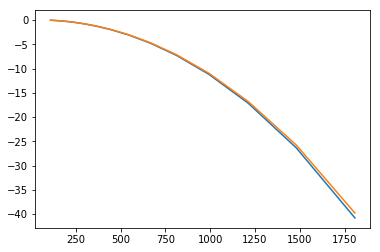

In [14]:
intdhsf=np.zeros((len(ttnpt)-1,3))
it=0.0
iterror=0.0
for i in xrange(len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhsf[i]/ttnpt[i]+dhsf[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhsferror[i]/ttnpt[i])**2.+(dhsferror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhsf[i,0]=T1
    intdhsf[i,1]=-it*T1
    intdhsf[i,2]=np.sqrt(iterror)*T1
#print intdhsf
plt.plot(intdhfcc[:,0],intdhfcc[:,1])
plt.plot(intdhsf[:,0],intdhsf[:,1])
plt.show()

## Now we put all the pieces together
## From the paper we have
###     $\dfrac{G(P,T_1)}{k_B T_1} = \dfrac{G(P,0)}{k_B T_1}+ \dfrac{G(P,T_0) - G(P,0)}{k_B T_0} -(3N-3) \ln(\dfrac{T_1}{T_0})- \int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{k_B T^2} dT.$
### so
### $G(P,T_1) = G(P,0)+ \dfrac{T_1}{T_0}(G(P,T_0) - G(P,0)) -(3N-3)k_B T_1 \ln(\dfrac{T_1}{T_0})-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$
### Note: These expressions are for systems with contrained center of mass

In [15]:
Gfcc=np.zeros((len(ttnpt)-1,3))
for i in xrange(len(ttnpt)-1):
    T1=intdhfcc[i,0]
    Gfcc[i,0]=T1
    Gfcc[i,1]=intdhfcc[i,1]+U0fcc+(T1/T0)*(GfccT0-U0fcc)-nfreefcc*kbev*T1*np.log(T1/T0)
    Gfcc[i,2]=intdhfcc[i,2]+(T1/T0)*GfccT0error
print Gfcc

[[  1.09000000e+02  -6.27396707e+03   6.50434140e-04]
 [  1.34000000e+02  -6.27506958e+03   1.16547216e-03]
 [  1.63000000e+02  -6.27853448e+03   1.73215896e-03]
 [  2.00000000e+02  -6.28574528e+03   2.46466832e-03]
 [  2.44000000e+02  -6.29766226e+03   3.36528339e-03]
 [  2.98000000e+02  -6.31635850e+03   4.52378538e-03]
 [  3.64000000e+02  -6.34421703e+03   6.00577357e-03]
 [  4.45000000e+02  -6.38459562e+03   7.89890220e-03]
 [  5.44000000e+02  -6.44156710e+03   1.03132963e-02]
 [  6.65000000e+02  -6.52057455e+03   1.33909471e-02]
 [  8.12000000e+02  -6.62801355e+03   1.72844673e-02]
 [  9.92000000e+02  -6.77373965e+03   2.22553386e-02]
 [  1.21100000e+03  -6.96852432e+03   2.86456957e-02]
 [  1.48000000e+03  -7.22974302e+03   3.70762179e-02]
 [  1.80700000e+03  -7.57484757e+03   4.84867908e-02]]


[[  1.09000000e+02  -5.75221798e+03   5.85821741e-04]
 [  1.34000000e+02  -5.75316791e+03   1.05493641e-03]
 [  1.63000000e+02  -5.75627471e+03   1.57095016e-03]
 [  2.00000000e+02  -5.76279783e+03   2.23683625e-03]
 [  2.44000000e+02  -5.77362121e+03   3.05337125e-03]
 [  2.98000000e+02  -5.79063997e+03   4.10327045e-03]
 [  3.64000000e+02  -5.81603681e+03   5.44947445e-03]
 [  4.45000000e+02  -5.85288781e+03   7.17080000e-03]
 [  5.44000000e+02  -5.90492686e+03   9.36464427e-03]
 [  6.65000000e+02  -5.97714545e+03   1.21606309e-02]
 [  8.12000000e+02  -6.07541315e+03   1.57026286e-02]
 [  9.92000000e+02  -6.20877386e+03   2.02313864e-02]
 [  1.21100000e+03  -6.38712337e+03   2.60371447e-02]
 [  1.48000000e+03  -6.62641716e+03   3.36755485e-02]
 [  1.80700000e+03  -6.94269102e+03   4.40536505e-02]]


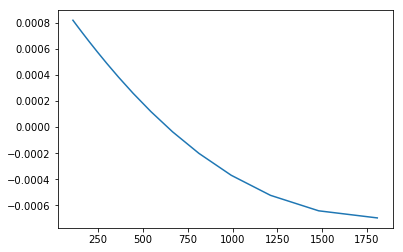

In [16]:
Gsf=np.zeros((len(ttnpt)-1,3))
for i in xrange(len(ttnpt)-1):
    T1=intdhsf[i,0]
    Gsf[i,0]=T1
    Gsf[i,1]=intdhsf[i,1]+U0sf+(T1/T0)*(GsfT0-U0sf)-nfreesf*kbev*T1*np.log(T1/T0)
    Gsf[i,2]=intdhsf[i,2]+(T1/T0)*GsfT0error

print Gsf

plt.plot(Gfcc[:,0],Gfcc[:,1]/natomfcc-Gsf[:,1]/natomsf)
#plt.plot(Gsf[:,0],Gsf[:,1]/natomsf)
plt.show()

# This the free energy associated with the center of mass
### $\Delta A_{cm}(N, V, T)=-k_B T\left(\ln\dfrac{V}{N \Lambda^3}+\dfrac{3}{2}\ln N\right)$
### $ \Lambda=(2\pi \hbar^2/(atomicmass\times dalton \times k_B  T))^{1/2}=17.458218 /\sqrt{T*atomicmass}~A$
### For FCC Co At 0K, $V/N=11.319473 A^3$
### Now we add this to the free energy in order to retrieve the free energy of the uncontrained system

In [18]:
massco=58.933195
vdivideN=11.319473
for i in xrange(len(Gfcc)):
    T1 = Gfcc[i,0]
    acm = -kbev*T1*(np.log(vdivideN/(17.458218/np.sqrt(T1*massco))**3.)+1.5*np.log(natomfcc))
    #print T1, acm
    Gfcc[i,1] += acm
print Gfcc

[[  1.09000000e+02  -6.27413527e+03   6.50434140e-04]
 [  1.34000000e+02  -6.27527993e+03   1.16547216e-03]
 [  1.63000000e+02  -6.27879449e+03   1.73215896e-03]
 [  2.00000000e+02  -6.28606960e+03   2.46466832e-03]
 [  2.44000000e+02  -6.29806420e+03   3.36528339e-03]
 [  2.98000000e+02  -6.31685710e+03   4.52378538e-03]
 [  3.64000000e+02  -6.34483546e+03   6.00577357e-03]
 [  4.45000000e+02  -6.38536323e+03   7.89890220e-03]
 [  5.44000000e+02  -6.44251960e+03   1.03132963e-02]
 [  6.65000000e+02  -6.52175619e+03   1.33909471e-02]
 [  8.12000000e+02  -6.62947735e+03   1.72844673e-02]
 [  9.92000000e+02  -6.77555360e+03   2.22553386e-02]
 [  1.21100000e+03  -6.97076997e+03   2.86456957e-02]
 [  1.48000000e+03  -7.23252586e+03   3.70762179e-02]
 [  1.80700000e+03  -7.57829190e+03   4.84867908e-02]]


In [19]:
for i in xrange(len(Gsf)):
    T1 = Gsf[i,0]
    acm = -kbev*T1*(np.log(vdivideN/(17.458218/np.sqrt(T1*massco))**3.)+1.5*np.log(natomsf))
    #print T1, acm
    Gsf[i,1] += acm
print Gsf

[[  1.09000000e+02  -5.75238496e+03   5.85821741e-04]
 [  1.34000000e+02  -5.75337676e+03   1.05493641e-03]
 [  1.63000000e+02  -5.75653289e+03   1.57095016e-03]
 [  2.00000000e+02  -5.76311990e+03   2.23683625e-03]
 [  2.44000000e+02  -5.77402040e+03   3.05337125e-03]
 [  2.98000000e+02  -5.79113522e+03   4.10327045e-03]
 [  3.64000000e+02  -5.81665115e+03   5.44947445e-03]
 [  4.45000000e+02  -5.85365041e+03   7.17080000e-03]
 [  5.44000000e+02  -5.90587324e+03   9.36464427e-03]
 [  6.65000000e+02  -5.97831960e+03   1.21606309e-02]
 [  8.12000000e+02  -6.07686781e+03   1.57026286e-02]
 [  9.92000000e+02  -6.21057666e+03   2.02313864e-02]
 [  1.21100000e+03  -6.38935540e+03   2.60371447e-02]
 [  1.48000000e+03  -6.62918336e+03   3.36755485e-02]
 [  1.80700000e+03  -6.94611503e+03   4.40536505e-02]]


# Now compute stacking fault free energy
### $G_\text{SF} = G_\text{sf} - \dfrac{N_\text{sf}}{N_\text{fcc}} G_\text{fcc}$

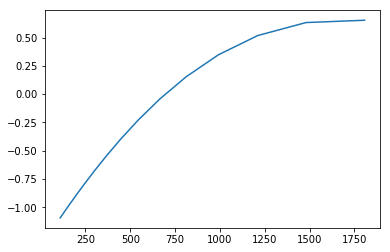

In [21]:
Gsfe=np.zeros((len(ttnpt)-1,3))
for i in xrange(len(ttnpt)-1):
    T1=Gsf[i,0]
    Gsfe[i,0]=T1
    Gsfe[i,1]=Gsf[i,1]-Gfcc[i,1]*natomsf/natomfcc
    Gsfe[i,2]=np.sqrt(Gsf[i,2]**2.0+Gfcc[i,2]**2.0)
    
plt.plot(Gsfe[:,0],Gsfe[:,1])
plt.show()